In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
#from catboost import CatBoostClassifier
from sklearn import svm
#import lightgbm as lgb
#from lightgbm import LGBMClassifier
#import xgboost as xgb

pd.set_option('display.max_columns', 100)


RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = False

import os

if(IS_LOCAL):
    PATH="Data"
else:
    PATH="Data"
print(os.listdir(PATH))

['cup98LRN.csv', 'cup98VAL.csv']


In [13]:
columns = ['AGE','RAMNTALL','NGIFTALL','LASTGIFT','LASTDATE','FISTDATE','NEXTDATE','TIMELAG','AVGGIFT','CONTROLN','MAXRAMNT','TARGET_B','TARGET_D']

In [23]:
filename = 'data/cup98LRN.csv'
p = 0.01  # 1% of the lines
# keep the header, then take only 1% of lines
# if random from [0,1] interval is greater than 0.01 the row will be skipped

data_df = pd.read_csv(filename,usecols=columns)


In [24]:
data_df[data_df['TARGET_D'] <= 0]

,AGE,RAMNTALL,NGIFTALL,MAXRAMNT,LASTGIFT,LASTDATE,FISTDATE,NEXTDATE,TIMELAG,AVGGIFT,CONTROLN,TARGET_B,TARGET_D
0,60.0,240.0,31,12.0,10.0,9512,8911,9003.0,4.0,7.741935,95515,0,0.0
1,46.0,47.0,3,25.0,25.0,9512,9310,9504.0,18.0,15.666667,148535,0,0.0
2,NaN,202.0,27,16.0,5.0,9512,9001,9101.0,12.0,7.481481,15078,0,0.0
3,70.0,109.0,16,11.0,10.0,9512,8702,8711.0,9.0,6.812500,172556,0,0.0
4,78.0,254.0,37,15.0,15.0,9601,7903,8005.0,14.0,6.864865,7112,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95406,50.0,81.0,24,9.0,2.0,9602,9003,9006.0,3.0,3.375000,35088,0,0.0
95407,NaN,25.0,1,25.0,25.0,9602,9602,NaN,NaN,25.000000,184568,0,0.0
95408,48.0,20.0,1,20.0,20.0,9603,9603,NaN,NaN,20.000000,122706,0,0.0
95409,60.0,58.0,7,10.0,10.0,9610,9410,9501.0,3.0,8.285714,189641,0,0.0


In [30]:
data_df.shape

(95412, 13)

In [28]:
data_df.describe()

,AGE,RAMNTALL,NGIFTALL,MAXRAMNT,LASTGIFT,LASTDATE,FISTDATE,NEXTDATE,TIMELAG,AVGGIFT,CONTROLN,TARGET_B,TARGET_D
count,71747.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,85439.000000,85439.000000,95412.000000,95412.000000,95412.000000,95412.000000
mean,61.611649,104.489351,9.602031,19.999790,17.313127,9548.100365,9135.651648,9151.022917,8.093739,13.347786,95778.176959,0.050759,0.793073
std,16.664199,118.580367,8.554342,25.067746,13.956630,49.235664,320.394019,294.257260,8.213242,10.769997,55284.596094,0.219506,4.429725
min,1.000000,13.000000,1.000000,5.000000,0.000000,9503.000000,0.000000,7211.000000,0.000000,1.285714,1.000000,0.000000,0.000000
25%,48.000000,40.000000,3.000000,14.000000,10.000000,9509.000000,8810.000000,8903.000000,4.000000,8.384615,47910.750000,0.000000,0.000000
50%,62.000000,78.000000,7.000000,17.000000,15.000000,9512.000000,9201.000000,9204.000000,6.000000,11.636364,95681.500000,0.000000,0.000000
75%,75.000000,131.000000,13.000000,23.000000,20.000000,9602.000000,9409.000000,9409.000000,11.000000,15.477955,143643.500000,0.000000,0.000000
max,98.000000,9485.000000,237.000000,5000.000000,1000.000000,9702.000000,9603.000000,9702.000000,1088.000000,1000.000000,191779.000000,1.000000,200.000000


In [27]:
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,AGE,TIMELAG,NEXTDATE,TARGET_D,TARGET_B,CONTROLN,AVGGIFT,FISTDATE,LASTDATE,LASTGIFT,MAXRAMNT,NGIFTALL,RAMNTALL
Total,23665.00000,9973.000000,9973.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,24.80296,10.452564,10.452564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
columns = ['RAMNTALL','MAXRAMNT','LASTGIFT','NUMPRM12','CARDPROM','NUMPROM']
data_df = pd.read_csv(filename,usecols=columns)

In [ ]:
from scipy.stats import skew 
import numpy as np  
import pylab as p  
  
x1 = data_df['RAMNTALL'].values
y1 = 1./(np.sqrt(2.*np.pi)) * np.exp( -.5*(x1)**2  ) 
  
p.plot(x1, y1, '*') 
  
print( '\nSkewness for data : ', skew(y1)) 


Skewness for data :  308.88347319004174


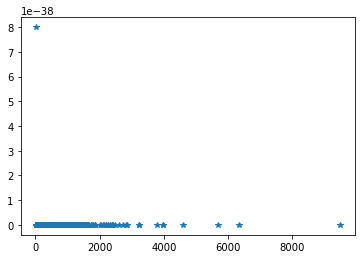

In [37]:
from scipy.stats import skew 
import numpy as np  
import pylab as p  
  
x1 = data_df['RAMNTALL'].values
y1 = 1./(np.sqrt(2.*np.pi)) * np.exp( -.5*(x1)**2  ) 
  
p.plot(x1, y1, '*') 
  
print( '\nSkewness for data : ', skew(y1)) 